In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.transforms.v2 as v2
from torchmetrics.functional import pairwise_cosine_similarity

import numpy as np
import pandas as pd
import math
from pathlib import Path
from collections import Counter
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.colors as mcolor
import random
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import sys

sys.path.append('./src')
from src.data import MultiSet, multi_collate, ImageTransforms, SignalTransforms
from src.module import TS_Transformer, ImageEncoder, BiModal, CLIPLoss, DistanceLoss, RankLoss

from torch.utils.tensorboard import SummaryWriter
from accelerate import Accelerator
from accelerate.utils import GradientAccumulationPlugin

import scienceplots
plt.style.use('science')

plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times"],
    "font.size": 12
})

# %matplotlib widget

In [2]:
torch.cuda.is_available()

True

In [3]:
data_path = Path('./data/CytoSense')

image_transforms = ImageTransforms()
signal_transforms = SignalTransforms(max_len=256)

In [4]:
id = 15

train_set = MultiSet(data_path=data_path, annotation_file=f'train_{id}.csv', 
                   image_transforms=v2.Compose([
                    image_transforms, v2.ColorJitter(0.5, 0.5)
                   ]),
                   signal_transforms=signal_transforms,
                   image_size=(224, 224))

test_set = MultiSet(data_path=data_path, annotation_file=f'test_{id}.csv', 
                    image_transforms=image_transforms,
                    signal_transforms=signal_transforms,
                    image_size=(224, 224))

valid_set = MultiSet(data_path=data_path, annotation_file=f'valid_{id}.csv', 
                    image_transforms=image_transforms,
                    signal_transforms=signal_transforms,
                    image_size=(224, 224))
                    
test_set.label_encoder = train_set.label_encoder
valid_set.label_encoder = train_set.label_encoder

In [5]:
bs = 25

train_loader = DataLoader(dataset=train_set, batch_size=bs, 
                        shuffle=True, num_workers=8, 
                        drop_last=True, collate_fn=multi_collate)

test_loader = DataLoader(dataset=test_set, batch_size=bs, 
                         num_workers=8, collate_fn=multi_collate)

valid_loader = DataLoader(dataset=valid_set, batch_size=bs, 
                         num_workers=8, collate_fn=multi_collate)

In [6]:
len(train_loader), len(valid_loader), len(valid_set)

(30, 6, 150)

(2002, tensor(0.3227))

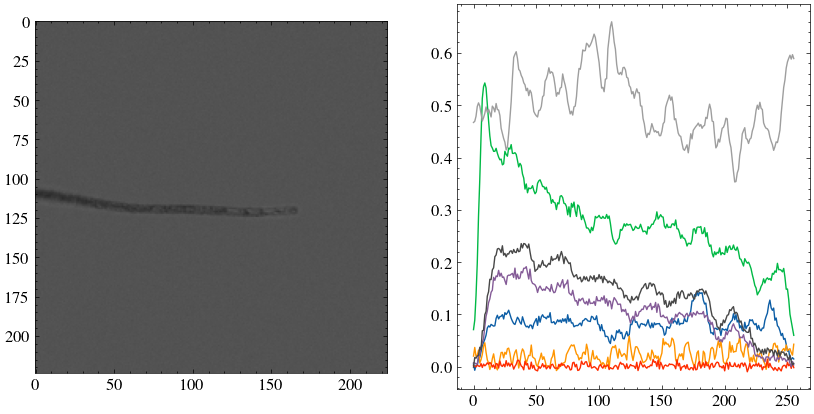

In [7]:
ix = 0

image, signal, y = train_set[ix]

fig, ax = plt.subplots(1, 2)

ax[0].imshow(image.permute(1, 2, 0))
ax[1].plot(signal)

fig.set_size_inches(10, 5)

train_set.X[ix], (image).mean()

## Cross-Modality Training

In [8]:
torch.cuda.empty_cache()

In [40]:
dim_space = 256

signal_encoder = TS_Transformer(dim_in=7, dim_out=256, num_head=8, num_layers=12,
                         dim_feedforward=1024, max_len=256)

image_encoder = ImageEncoder('resnet18')

model = BiModal(image_encoder, signal_encoder, dim_space)

classifier = nn.Sequential(
    nn.Linear(dim_space, 4096),
    nn.GELU(),
    nn.Linear(4096, 4096),
    nn.GELU(),
    nn.Linear(4096, id)
)

crossmodal_criterion = RankLoss(margin=2.5)
classification_criterion = nn.CrossEntropyLoss()

parameters = list(model.parameters()) \
    + list(crossmodal_criterion.parameters()) \
    + list(classifier.parameters())
optimizer = optim.Adam(parameters, lr=1e-4, weight_decay=1e-10)

plugin = GradientAccumulationPlugin(num_steps=4, 
                                    sync_with_dataloader=False)
accelerator = Accelerator(mixed_precision='fp16', 
                          gradient_accumulation_plugin=plugin)

writer = SummaryWriter()

model, classifier = accelerator.prepare(model, classifier)
crossmodal_criterion, classification_criterion = accelerator.prepare(
    crossmodal_criterion, classification_criterion
)
optimizer = accelerator.prepare(optimizer)
train_loader, test_loader, valid_loader = accelerator.prepare(
    train_loader, test_loader, valid_loader
)

print(sum(torch.numel(p) for p in model.parameters()))

20919616


In [11]:
def step(model, classifier, batch, crossmodal_criterion, 
         classification_criterion, alpha):
    image, signal, y = batch

    out = model(image, signal)
    loss = alpha * crossmodal_criterion(*out)

    x = torch.cat(out, 0)
    y = torch.tile(y, (2,))
    out = classifier(x)
    loss += (1 - alpha) * classification_criterion(out, y)
    
    return loss


def set_train(*modules):
    for module in modules:
        module.train()


def set_eval(*modules):
    for module in modules:
        module.eval()


@torch.no_grad()
def validate(model, classifier, crossmodal_criterion, 
             classification_criterion, dataloader, alpha):
    set_eval(model, classifier, crossmodal_criterion)
    loss = 0
    for batch in dataloader:
        loss += step(model, classifier, batch, crossmodal_criterion,
                     classification_criterion, alpha).detach().item()
    return loss / len(dataloader)


In [41]:
epochs = 50
steps = len(train_loader) * epochs
iterator = tqdm(range(1, steps + 1))

generator = iter(train_loader)

accum_steps = accelerator.gradient_accumulation_steps
accumulated_loss = 0

alpha = .5

set_train(model, classifier, crossmodal_criterion)

for i in iterator:

    try:
        batch = next(generator)
    except StopIteration:
        generator = iter(train_loader)
        batch = next(generator)

    with accelerator.accumulate(model, classifier, crossmodal_criterion):
        optimizer.zero_grad()
        loss = step(model, classifier, batch, crossmodal_criterion,
                    classification_criterion, alpha)
        accelerator.backward(loss)
        optimizer.step()
        accumulated_loss += loss.detach().item()

    if i % accum_steps == 0:
        accumulated_loss /= accum_steps
        valid_loss = validate(model, classifier, crossmodal_criterion,
                              classification_criterion, valid_loader, alpha)
        writer.add_scalar('Loss/train:', accumulated_loss, i // accum_steps)
        writer.add_scalar('Loss/validation:', valid_loss, i // accum_steps)
        accumulated_loss = 0
        set_train(model, classifier, crossmodal_criterion)


100%|██████████| 1500/1500 [07:34<00:00,  3.30it/s]


## Testing the classifier

In [42]:
set_eval(model, classifier)

I = []
S = []
label = []
pred = []

for image, signal, y in tqdm(test_loader):
    with torch.no_grad():
        encoding_1, encoding_2 = model(image, signal)
        I.append(encoding_1)
        S.append(encoding_2)
        pred.append((classifier(encoding_1) + classifier(encoding_2)))
        label.append(y)

I = torch.cat(I)
S = torch.cat(S)
pred = torch.cat(pred).cpu()
label = torch.cat(label).cpu()

100%|██████████| 215/215 [00:07<00:00, 28.92it/s]


In [43]:
I_np = I.cpu().numpy()
S_np = S.cpu().numpy()
E = np.concat((I_np, S_np), 0)
label_np = label.numpy()
label_E = np.tile(label_np, (2,))

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

reduced = TSNE(2, perplexity=20, early_exaggeration=20).fit_transform(E)
# reduced = PCA(2).fit_transform(E)

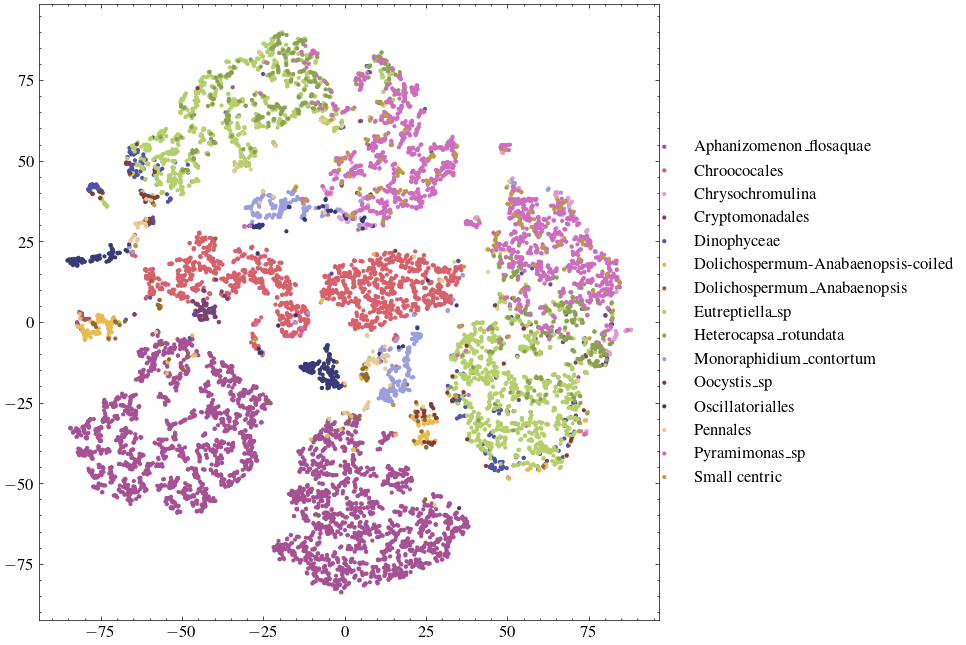

In [44]:
fig = plt.figure()
ax = fig.add_subplot()#projection='3d')

palette = plt.colormaps.get_cmap('tab20b')
colors = random.sample(palette.colors, id)

for y, c in zip(np.unique(label_E), colors):
    class_name = test_set.label_encoder.inverse_transform([y])[0]
    e = reduced[label_E == y]
    ax.scatter(*zip(*e), label=class_name, s=4, c=[c]*len(e))

fig.set_size_inches(8, 8)
ax.legend(loc=7, bbox_to_anchor=(1.5, .5))
plt.show()

/home/veikka/miniconda3/envs/dippa/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:2036: UndefinedMetricWarning: 'k' (15) greater than or equal to 'n_classes' (15) will result in a perfect score and is therefore meaningless.
  warnings.warn(


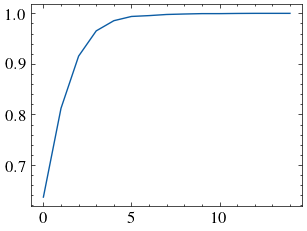

In [45]:
from sklearn.metrics import top_k_accuracy_score

pred_np = pred.numpy()

plt.plot([top_k_accuracy_score(label_np, pred_np, k=k) for k in range(1, id+1)])

In [46]:
from sklearn.metrics import classification_report

pred_class = pred.argmax(1)

names = test_set.label_encoder.inverse_transform(list(range(id)))
pd.DataFrame(classification_report(label, pred_class, target_names=names, output_dict=True)).T

,precision,recall,f1-score,support
Aphanizomenon_flosaquae,0.999265,0.845245,0.915825,1609.000000
Chroococales,0.837433,0.998724,0.910995,784.000000
Chrysochromulina,0.300699,0.895833,0.450262,96.000000
Cryptomonadales,0.955882,0.902778,0.928571,72.000000
Dinophyceae,0.567742,0.520710,0.543210,169.000000
Dolichospermum-Anabaenopsis-coiled,0.801653,0.915094,0.854626,106.000000
Dolichospermum_Anabaenopsis,0.101695,0.428571,0.164384,28.000000
Eutreptiella_sp,0.930041,0.467909,0.622590,966.000000
Heterocapsa_rotundata,0.271394,0.397849,0.322674,279.000000
Monoraphidium_contortum,0.972477,0.522167,0.679487,203.000000


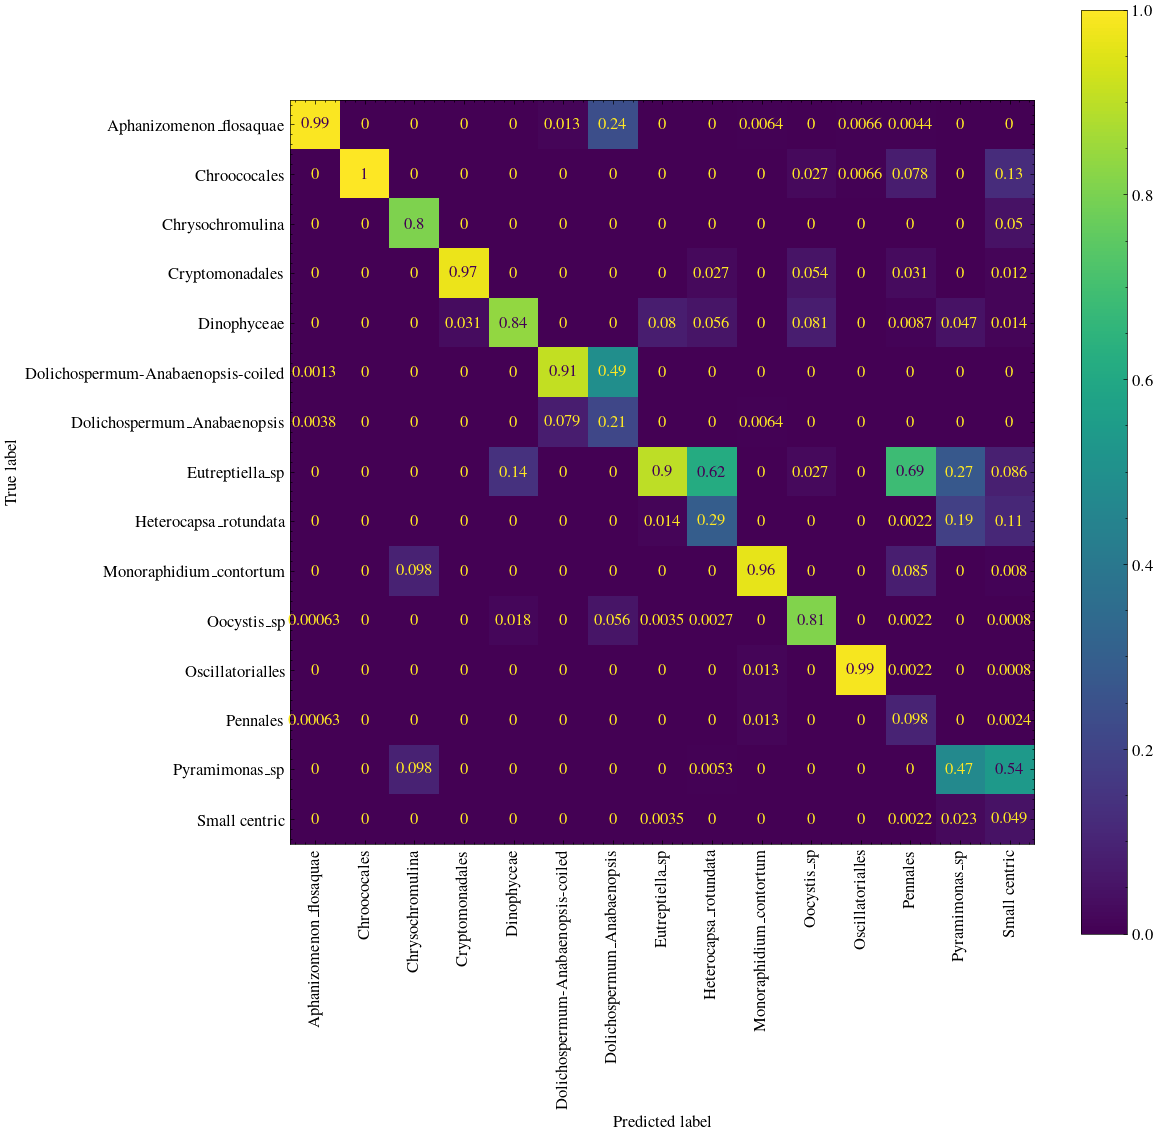

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots()
cm = confusion_matrix(label, pred_class, normalize='pred')
ConfusionMatrixDisplay(cm, display_labels=names).plot(xticks_rotation=90, ax=ax)
fig.set_size_inches(12, 12)

